In [138]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Extraccion y manipulación de datos

In [139]:
def plot_full_cold_hot(T,L):
    df_cold = pd.read_csv(f'./Datos/Ising/ising_2d_cold_t{T}_{L}.csv')
    x = df_cold["sweep"]
    y_cold_tot = df_cold["H"]
    y_cold_term = df_cold["H_t"].dropna()

    df_hot = pd.read_csv(f'./Datos/Ising/ising_2d_hot_t{T}_{L}.csv')
    y_hot_tot = df_hot["H"]
    y_hot_term = df_hot["H_t"].dropna()


    y_cold_tot = y_cold_tot/L**2 # Normalizamos la energía por sitio
    y_hot_tot = y_hot_tot/L**2
    y_cold_term = y_cold_term/L**2 # Normalizamos la energía por sitio
    y_hot_term = y_hot_term/L**2
    
    mean_cold = y_cold_term.mean()
    err_cold = np.sqrt(y_cold_term.var() / len(y_cold_term))

    mean_hot = y_hot_term.mean()
    err_hot = np.sqrt(y_hot_term.var() / len(y_hot_term))

    min=-2
    
    plt.figure(figsize=(20,5))

    plt.plot(x,y_cold_tot,ls="-",marker="o",label=f"Cold mean:{round(mean_cold,3)}$\\pm$ {round(err_cold,3)}")#cold
    plt.plot(x,y_hot_tot,ls="-",marker="o",label=f"Hot mean:{round(mean_hot,3)}$\\pm${round(err_hot,3)}")#hot

    plt.xlabel('Sweep')
    plt.ylabel('$<H> / V$')
    plt.title('Ising model 2D\n L=%d, T=%1.1f'%(L,T))

    plt.axhline(y=-2, color='k',label="$H_{min}$ / V = -2")

    plt.axhline(y=mean_cold, color='r')
    plt.axhline(y=mean_hot, color='b')

    plt.legend()

    plt.show()

In [140]:
def info_dict(T,L,start = "hot"):

    df = pd.read_csv(f'./Datos/Ising/ising_2d_hot_t{T}_{L}.csv') if start=="hot" else pd.read_csv(f'./Datos/Ising/ising_2d_cold_t{T}_{L}.csv')
    H = df["H_t"].dropna()
    M = df["M_t"].dropna()
    
    mean_H = H.mean()
    stderr_H = np.sqrt(H.var()/len(H))
    mean_H2 = (H**2).mean()

    mean_M = M.mean()
    stderr_M = np.sqrt(M.var()/len(M))/L**2
    mean_M2 = (M**2).mean()

    Cv = (mean_H2 - mean_H**2)/L**2
    stderr_cv = ((H - mean_H)**2).mean()/L**2

    m = M.abs().mean()/L**2
    stderr_m = np.sqrt(M.abs().var()/len(M))/L**2

    chi_m = (mean_M2 - (M.abs().mean())**2)/L**2
    stderr_chi = ((M-M.abs().mean())**2).mean()/L**2
    
    dic = {"H":mean_H/L**2,"stderr_H":stderr_H/L**2,
           "M":mean_M/L**2,"stderr_M":stderr_M/L**2,
           "Cv":Cv,"stderr_cv":stderr_cv,
           "chi_m":chi_m,"stderr_chi":stderr_chi,
           "m":m,"stderr_m":stderr_m}
    return dic

In [141]:
def L_arrays(L,T_min = 1.5,T_max = 3.8):

    fine_T_min = 2.1
    fine_T_max = 2.4
    fine_step = 0.03

    T_values1 = np.arange(T_min,fine_T_min,0.1).round(1)
    T_values2 = np.arange(fine_T_min,fine_T_max+fine_step,fine_step).round(2)
    T_values3 = np.arange(fine_T_max+0.1,T_max+0.1,0.1).round(1)

    T_values = np.concatenate((T_values1,T_values2,T_values3))
    
    H = np.zeros(len(T_values))
    stderr_H = np.zeros(len(T_values))

    M = np.zeros(len(T_values))
    stderr_M = np.zeros(len(T_values))
    
    Cv = np.zeros(len(T_values))
    stderr_cv = np.zeros(len(T_values))

    chi_m = np.zeros(len(T_values))
    stderr_chi = np.zeros(len(T_values))

    m = np.zeros(len(T_values))
    stderr_m = np.zeros(len(T_values))

    for i,T in enumerate(T_values):
        dic = info_dict(T,L)

        H[i] = dic["H"]
        stderr_H[i] = dic["stderr_H"]

        M[i] = dic["M"] 
        stderr_M[i] = dic["stderr_M"]

        Cv[i] = dic["Cv"]
        stderr_cv[i] = dic["stderr_cv"]

        chi_m[i] = dic["chi_m"]
        stderr_chi[i] = dic["stderr_chi"]
        
        m[i] = dic["m"]
        stderr_m[i] = dic["stderr_m"]

    return {"T":T_values,
            "H":H,"stderr_H":stderr_H,
            "M":M,"stderr_M":stderr_M,
            "Cv":Cv,"stderr_cv":stderr_cv,
            "chi_m":chi_m,"stderr_chi":stderr_chi,
            "m":m,"stderr_m":stderr_m}


# Comparación de energías, Hot start vs Cold start

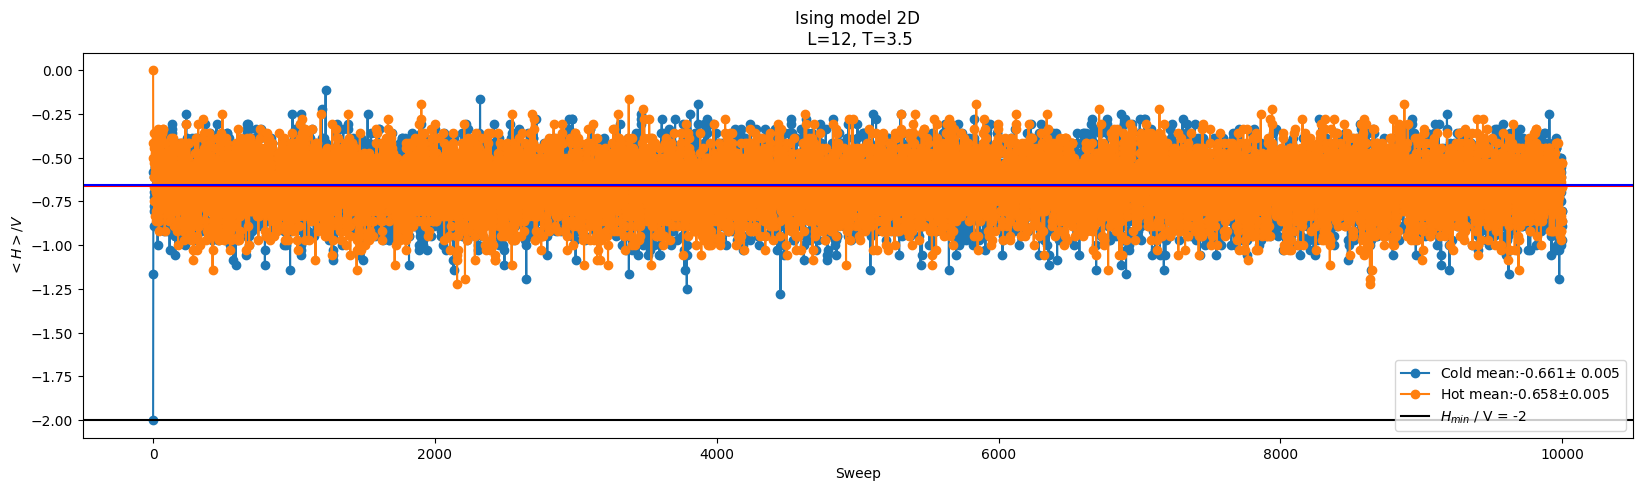

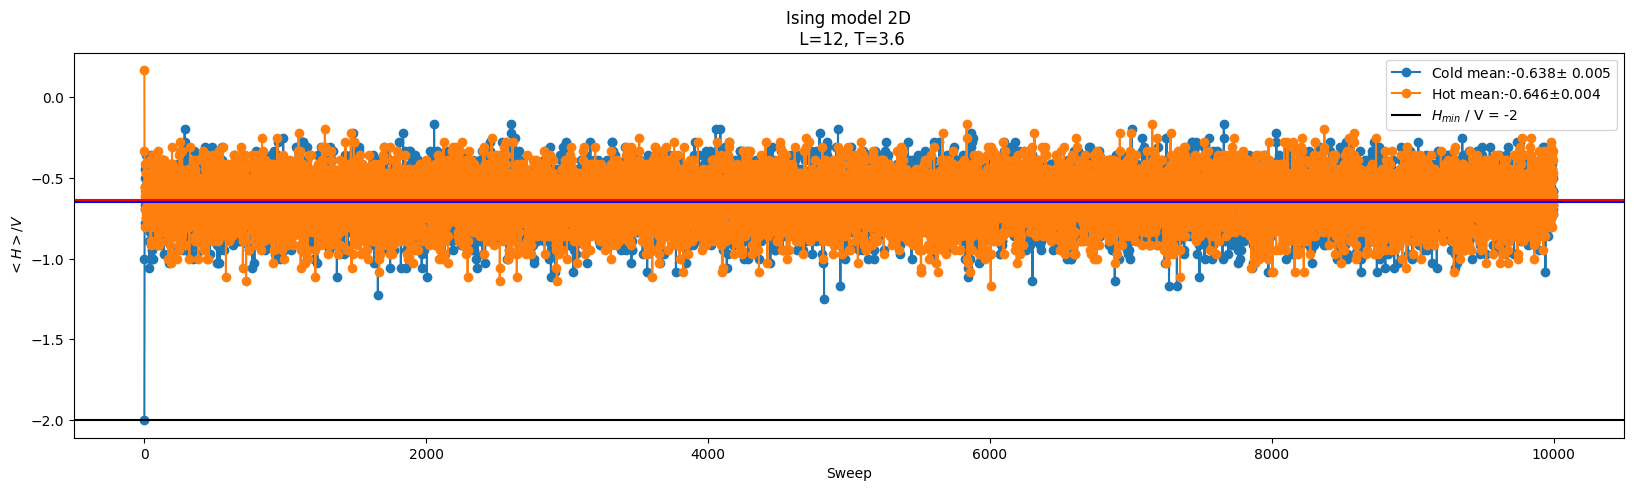

In [162]:
T_vaues=[2.1,3.8]

for T in T_values:
    plot_full_cold_hot(T=round(T, 1), L=12)

# Cantidades físicas

## Densidad de energía y temperatura  ($\frac{<H>}{V}$ vs T)

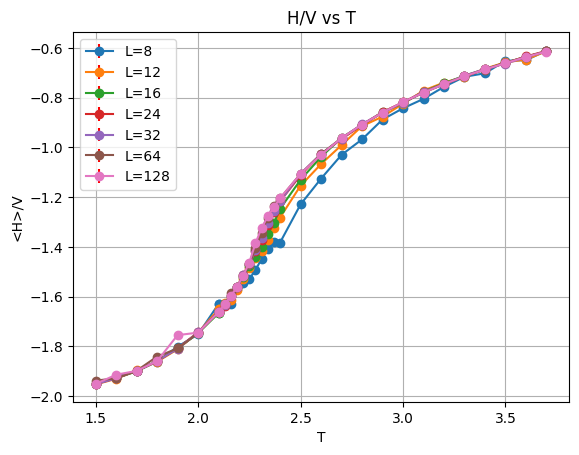

In [143]:
L_values = [8,12,16,24,32,64,128]

T_i = 1.5
T_f = 3.8

plt.title("H/V vs T")
plt.grid()
plt.xlabel("T")
plt.ylabel("<H>/V")

for L in L_values:
    dic = L_arrays(L)

    x = dic["T"].tolist()
    t_i = x.index(T_i)
    t_f = x.index(T_f)

    y = dic["H"]
    yerr = dic["stderr_H"]

    plt.errorbar(x[t_i:t_f],y[t_i:t_f],yerr[t_i:t_f],marker="o",ls="-",ecolor="r",label=f"{L=}")

plt.legend()
plt.show()

## Capacidad calorífica y temperatura ($C_v$ vs $T$)

$$C_v = (<H²>-<H>²)\frac{1}{V}$$

$$err = <(H-<H>)²>\frac{1}{V} $$

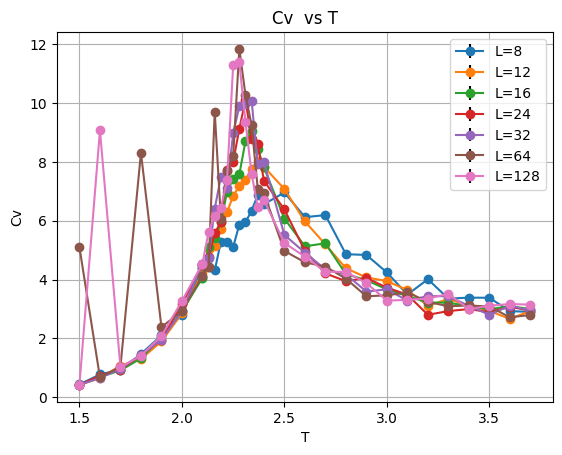

In [159]:
L_values = [8,12,16,24,32,64,128]

T_i = 1.5
T_f = 3.8

plt.title("Cv  vs T")
plt.grid()
plt.xlabel("T")
plt.ylabel("Cv")

for L in L_values:
    dic = L_arrays(L)
    
    x = dic["T"].tolist()
    t_i = x.index(T_i)
    t_f = x.index(T_f)

    y = dic["Cv"]

    yerr = dic["stderr_cv"]
    yerr = np.zeros(len(x))

    plt.errorbar(x[t_i:t_f],y[t_i:t_f],yerr[t_i:t_f],marker="o",ls="-",ecolor="k",label=f"{L=}")

plt.legend()
plt.show()

## Magnetización vs T ($M$ vs $T$)

$$ M=\sum_{x,y}s_{x,y}$$

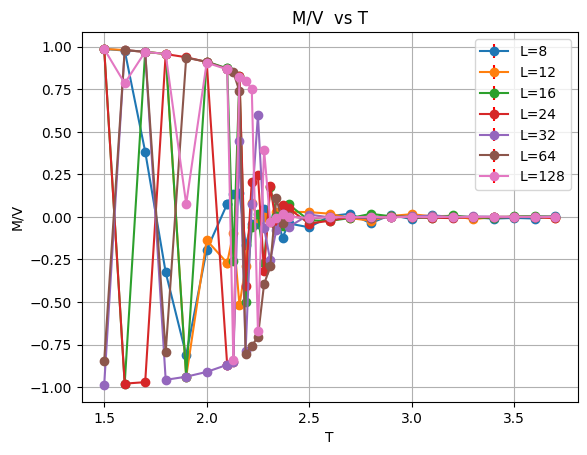

In [145]:
L_values = [8,12,16,24,32,64,128]

T_i = 1.5
T_f = 3.8

plt.title("M/V  vs T")
plt.grid()
plt.xlabel("T")
plt.ylabel("M/V")

for L in L_values:
    dic = L_arrays(L)
    
    x = dic["T"].tolist()
    t_i = x.index(T_i)
    t_f = x.index(T_f)

    y = dic["M"]
    yerr = dic["stderr_M"]
    

    plt.errorbar(x[t_i:t_f],y[t_i:t_f],yerr[t_i:t_f],marker="o",ls="-",ecolor="r",label=f"{L=}")

plt.legend()
plt.show()

## Densidad de magnetización vs T ($m$ vs $T$)

$$m=\frac{1}{V}<|M|>$$

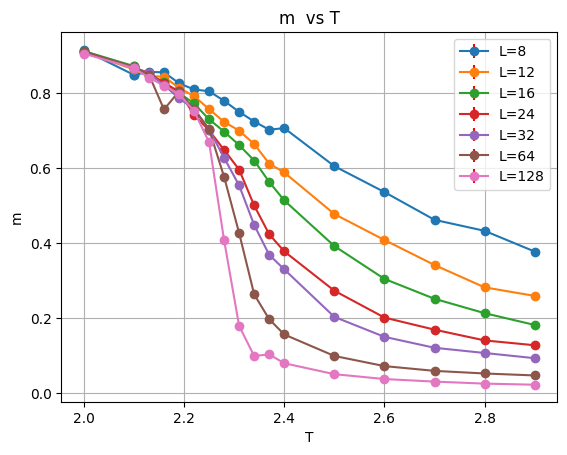

In [146]:
L_values = [8,12,16,24,32,64,128]

T_i = 2.0
T_f = 3.0

plt.title("m  vs T")
plt.grid()
plt.xlabel("T")
plt.ylabel("m")

for L in L_values:
    dic = L_arrays(L)
    x = dic["T"].tolist()
    t_i = x.index(T_i)
    t_f = x.index(T_f)
    
    y = dic["m"]
    yerr = dic["stderr_m"]
   

    plt.errorbar(x[t_i:t_f],y[t_i:t_f],yerr[t_i:t_f],marker="o",ls="-",ecolor="r",label=f"{L=}")

plt.legend()
plt.show()

## Suceptibilidad magnética vs T ($\chi_m$ vs $T$)

$$ \chi_m = (<M²>-<|M|>²)\frac{1}{V} $$

$$ err = <(M - <|M|>)²>\frac{1}{V}$$

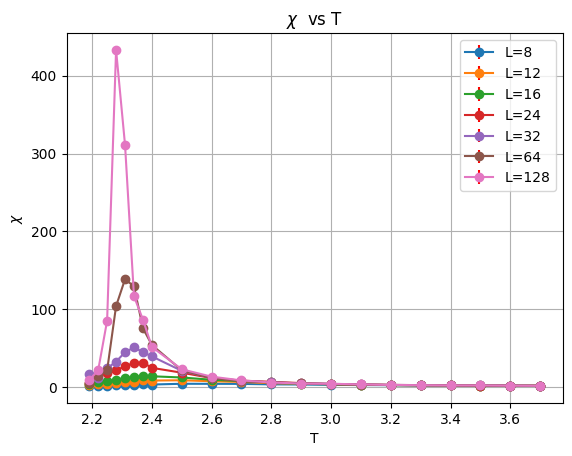

In [154]:
L_values = [8,12,16,24,32,64,128]

T_i = 2.19
T_f = 3.8

plt.title("$\\chi$  vs T")
plt.grid()
plt.xlabel("T")
plt.ylabel("$\\chi$")



for L in L_values[:]:
    dic = L_arrays(L)
    x = dic["T"].tolist()
    t_i = x.index(T_i)
    t_f = x.index(T_f)

    y = dic["chi_m"]
    yerr = dic["stderr_chi"]
    yerr = np.zeros(len(x))

    plt.errorbar(x[t_i:t_f],y[t_i:t_f],yerr[t_i:t_f],marker="o",ls="-",ecolor="r",label=f"{L=}")

plt.legend()
plt.show()

## Funcion de correlación 

$$\sigma_j = \frac{1}{L} \sum_i s_{i,j}$$

$$d = |x_i - y_j| = |0-y_j| = |y_j|$$ 

$$corr(j)  = <\sigma_0  \sigma_j> j\in{0,...,L}$$

$d = 0$:

$\frac{1}{1}(\sigma_0 \sigma_0)$

$d = 1$:

$(\sigma_0 \sigma_1)$



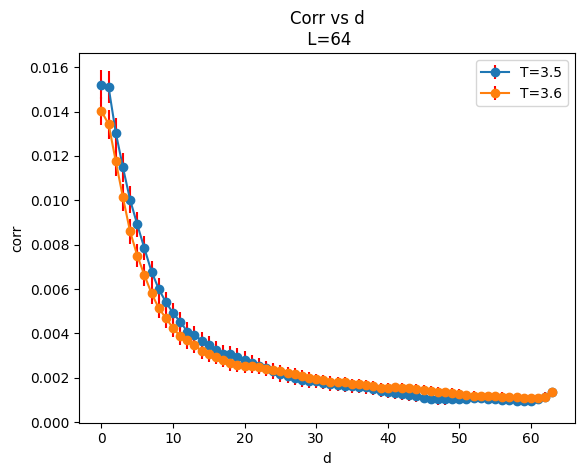

In [160]:
L=64

T_min = 3.5
T_max = 3.6
T_values = np.round(np.arange(T_min,T_max,0.1),1).tolist()

for T in T_values:
    

    df = pd.read_csv(f'./Datos/Ising/ising_2d_corr_t{T}_{L}.csv')
    df["index"] = df.groupby("d").cumcount()
    df = df.pivot(index='index', columns='d', values='corr').reset_index(drop=True)

    df = {"d":np.arange(L),
        "corr_mean": df.mean().to_numpy(),
        "stderr_corr":np.sqrt(df.var()/len(df)).to_numpy()}


    plt.errorbar(df["d"],df["corr_mean"],df["stderr_corr"],marker="o",ls="-",ecolor="r",label=f"{T=}")
    plt.title(f"Corr vs d\n {L=}")
    plt.xlabel("d")
    plt.ylabel("corr")
    plt.legend()
    plt.grid()
plt.show()